In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import binarize

In [3]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [4]:
heart = pd.read_csv('framingham.csv')
heart.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Data Cleaning

In [5]:
heart = heart.dropna()

In [6]:
heart.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [7]:
x = heart.drop('TenYearCHD', axis=1)
y = heart['TenYearCHD']

In [8]:
heart['TenYearCHD'].value_counts()

0    3099
1     557
Name: TenYearCHD, dtype: int64

## Feature selection

In [9]:
#extract the 10 best features
features = SelectKBest(score_func=chi2, k=10)
scores = features.fit(x,y).scores_
columns = x.columns

df = pd.DataFrame()
df['score'] = scores
df['column'] = columns

best_feat = df.sort_values(by='score', ascending=False).head(10)
best_feat

,score,column
10,669.506552,sysBP
14,379.583137,glucose
1,295.507761,age
9,249.153078,totChol
4,156.567318,cigsPerDay
11,142.878574,diaBP
7,82.967184,prevalentHyp
8,31.027987,diabetes
5,28.153003,BPMeds
0,17.120430,male


In [10]:
best_features = list(best_feat['column'])

best_features

['sysBP',
 'glucose',
 'age',
 'totChol',
 'cigsPerDay',
 'diaBP',
 'prevalentHyp',
 'diabetes',
 'BPMeds',
 'male']

In [11]:
heart_new = heart[best_features]
heart_new['TenYearCHD'] = y

heart_new.head()

,sysBP,glucose,age,totChol,cigsPerDay,diaBP,prevalentHyp,diabetes,BPMeds,male,TenYearCHD
0,106.0,77.0,39,195.0,0.0,70.0,0,0,0.0,1,0
1,121.0,76.0,46,250.0,0.0,81.0,0,0,0.0,0,0
2,127.5,70.0,48,245.0,20.0,80.0,0,0,0.0,1,0
3,150.0,103.0,61,225.0,30.0,95.0,1,0,0.0,0,1
4,130.0,85.0,46,285.0,23.0,84.0,0,0,0.0,0,0


In [12]:
corr = heart_new.corr()

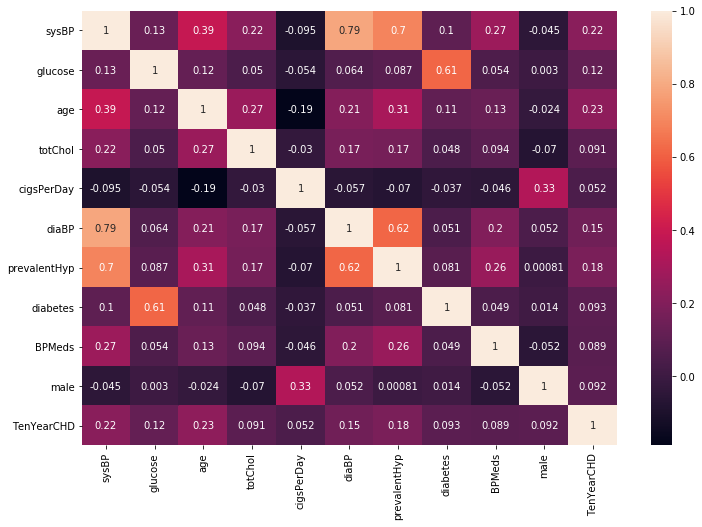

In [13]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr, annot=True)

## Feature Scaling
I will be scaling my data because I'd be using different models that use distance measure between datapoints

In [14]:
scaler = MinMaxScaler(feature_range=(0,1)) 

#assign scaler to column:
heart_scaled = pd.DataFrame(scaler.fit_transform(heart_new), columns=heart_new.columns)

heart_scaled.head()

,sysBP,glucose,age,totChol,cigsPerDay,diaBP,prevalentHyp,diabetes,BPMeds,male,TenYearCHD
0,0.106383,0.104520,0.184211,0.168378,0.000000,0.232804,0.0,0.0,0.0,1.0,0.0
1,0.177305,0.101695,0.368421,0.281314,0.000000,0.349206,0.0,0.0,0.0,0.0,0.0
2,0.208038,0.084746,0.421053,0.271047,0.285714,0.338624,0.0,0.0,0.0,1.0,0.0
3,0.314421,0.177966,0.763158,0.229979,0.428571,0.497354,1.0,0.0,0.0,0.0,1.0
4,0.219858,0.127119,0.368421,0.353183,0.328571,0.380952,0.0,0.0,0.0,0.0,0.0


## Data splitting

In [15]:
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(heart_scaled, heart_scaled['TenYearCHD']):
    train = heart_scaled.loc[train_index]
    test = heart_scaled.loc[test_index]
    
    x_test = test.drop("TenYearCHD", axis=1)
    y_test = test["TenYearCHD"]

## Sampling

In [16]:
#Separate majority and minority classes
majority = train[train["TenYearCHD"] == 0]
minority = train[train["TenYearCHD"] == 1]

In [17]:
#upsample minority data
minority_upsampled = resample(minority,
                              n_samples =2500,
                              random_state=65)

#combine with mojority dataframe
upsampled = pd.concat([majority, minority_upsampled],axis=0)

In [18]:
#downsample majority data
majority_downsampled = resample(majority,
                                n_samples=511,
                                random_state=65)

downsampled = pd.concat([minority,majority_downsampled],axis=0)

In [19]:
print('Upsampled data: ', '\n', upsampled['TenYearCHD'].value_counts())
print('-----')
print('Downsampled data: ', '\n', downsampled['TenYearCHD'].value_counts())

Upsampled data:  
 1.0    2500
0.0    2479
Name: TenYearCHD, dtype: int64
-----
Downsampled data:  
 0.0    511
1.0    445
Name: TenYearCHD, dtype: int64


In [20]:
print('Initial train set: ', '\n', train['TenYearCHD'].value_counts())

Initial train set:  
 0.0    2479
1.0     445
Name: TenYearCHD, dtype: int64


In [21]:
#splitting dependent and independent variables
downsampled_X = downsampled.drop('TenYearCHD', axis=1)
downsampled_Y = downsampled['TenYearCHD']


upsampled_X = upsampled.drop('TenYearCHD', axis=1)
upsampled_Y = upsampled['TenYearCHD']

## Upsampled data

### Choosing the best hyperparameters

In [20]:
#knn
hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2, 3]
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn,param_grid=hyperparameters,cv=10)

grid.fit(upsampled_X, upsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.9297010981551962
{'algorithm': 'brute', 'n_neighbors': 1, 'p': 2, 'weights': 'distance'}


In [21]:
#lr
hyperparameters = {
    "max_iter": range(100,200,2),
    "solver" : ['newton-cg', 'lbfgs', 'liblinear'],
    "C": [0.5, 0.1, 1.0]
}

lr = LogisticRegression()
grid = GridSearchCV(lr,param_grid=hyperparameters,cv=10)

grid.fit(upsampled_X, upsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.679646958053542
{'C': 0.5, 'max_iter': 100, 'solver': 'liblinear'}


In [22]:
#randomforest
hyperparameters = {
    "n_estimators": range(100,151,10), 
    "max_depth": [2,3,4,5,7,9],
    'min_samples_split' : [2, 4, 5],
    'min_samples_leaf' :[1,2,3,4,5]
}

clf = RandomForestClassifier()
grid = GridSearchCV(clf,param_grid=hyperparameters,cv=10)

grid.fit(upsampled_X, upsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.854583323232568
{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 130}


In [23]:
#tree
hyperparameters = {
    "max_depth": [2,4,7,9,10,12,15],
    'min_samples_leaf' :[1,2,3,4,5],
    'max_features' :[2, 4, 6]
}

tree = DecisionTreeClassifier()
grid = GridSearchCV(tree,param_grid=hyperparameters,cv=10)

grid.fit(upsampled_X, upsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.896568164004105
{'max_depth': 15, 'max_features': 6, 'min_samples_leaf': 1}


In [24]:
#svc
hyperparameters = {
    'C' : [1.0], 
    'kernel' : ['rbf', 'linear'],
    'degree' :[1,2,3], 
    'gamma' : ['scale', 'auto']
}

svc = SVC()
grid = GridSearchCV(svc,param_grid=hyperparameters,cv=10)

grid.fit(upsampled_X, upsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.6842674521021712
{'C': 1.0, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


### Modelling

In [29]:
knn = KNeighborsClassifier(algorithm ='brute', n_neighbors= 1, p= 1, weights ='distance')
lr = LogisticRegression(C=0.5, max_iter = 100, solver = 'liblinear')
tree = DecisionTreeClassifier(max_depth =15, max_features = 6, min_samples_leaf = 1)
clf = RandomForestClassifier(max_depth = 9, min_samples_leaf =1, min_samples_split =2, n_estimators =150)
svc = SVC(C =1.0, degree =1, gamma = 'scale', kernel = 'rbf', probability=True)

In [30]:
lr.fit(upsampled_X, upsampled_Y)
knn.fit(upsampled_X, upsampled_Y)
svc.fit(upsampled_X, upsampled_Y)
tree.fit(upsampled_X, upsampled_Y)
clf.fit(upsampled_X, upsampled_Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Accuracy

In [31]:
print('Logistic Regression: ', accuracy_score(y_test, lr.predict(x_test)))
print('KNN: ', accuracy_score(y_test, knn.predict(x_test)))
print('Decision Tree: ', accuracy_score(y_test, tree.predict(x_test)))
print('Random Forest: ', accuracy_score(y_test, clf.predict(x_test)))
print('SVC: ', accuracy_score(y_test, svc.predict(x_test)))

Logistic Regression:  0.6857923497267759
KNN:  0.7773224043715847
Decision Tree:  0.75
Random Forest:  0.7513661202185792
SVC:  0.6967213114754098


#### Recall

In [32]:
print('Logistic Regression: ', recall_score(y_test, lr.predict(x_test)))
print('KNN: ', recall_score(y_test, knn.predict(x_test)))
print('Decision Tree: ', recall_score(y_test, tree.predict(x_test)))
print('Random Forest: ', recall_score(y_test, clf.predict(x_test)))
print('SVC: ', recall_score(y_test, svc.predict(x_test)))


Logistic Regression:  0.6696428571428571
KNN:  0.19642857142857142
Decision Tree:  0.3482142857142857
Random Forest:  0.45535714285714285
SVC:  0.6071428571428571


#### Precision

In [33]:
print('Logistic Regression: ', precision_score(y_test, lr.predict(x_test)))
print('KNN: ', precision_score(y_test, knn.predict(x_test)))
print('Decision Tree: ', precision_score(y_test, tree.predict(x_test)))
print('Random Forest: ', precision_score(y_test, clf.predict(x_test)))
print('SVC: ', precision_score(y_test, svc.predict(x_test)))

Logistic Regression:  0.2798507462686567
KNN:  0.23157894736842105
Decision Tree:  0.26174496644295303
Random Forest:  0.29651162790697677
SVC:  0.2764227642276423


#### F1

In [34]:
print('Logistic Regression: ', f1_score(y_test, lr.predict(x_test)))
print('KNN: ', f1_score(y_test, knn.predict(x_test)))
print('Decision Tree: ', f1_score(y_test, tree.predict(x_test)))
print('Random Forest: ', f1_score(y_test, clf.predict(x_test)))
print('SVC: ', f1_score(y_test, svc.predict(x_test)))


Logistic Regression:  0.39473684210526316
KNN:  0.21256038647342995
Decision Tree:  0.29885057471264365
Random Forest:  0.35915492957746475
SVC:  0.3798882681564245


#### CONFUSION MATRIX

In [35]:
print('Logistic Regression: ', confusion_matrix(y_test, lr.predict(x_test)))
print('---------')
print('KNN: ', confusion_matrix(y_test, knn.predict(x_test)))
print('---------')
print('Decision Tree: ', confusion_matrix(y_test, tree.predict(x_test)))
print('---------')
print('Random Forest: ', confusion_matrix(y_test, clf.predict(x_test)))
print('---------')
print('SVC: ', confusion_matrix(y_test, svc.predict(x_test)))

Logistic Regression:  [[427 193]
 [ 37  75]]
---------
KNN:  [[547  73]
 [ 90  22]]
---------
Decision Tree:  [[510 110]
 [ 73  39]]
---------
Random Forest:  [[499 121]
 [ 61  51]]
---------
SVC:  [[442 178]
 [ 44  68]]


<b>Threshold Tweaking</b>

Classification algorithms use probability measures to predict labels. In a binary classification, the algorithm picks the class with the highest probability. By reducing the probability threshold, the chances of the minority class being chosen increases.

In [36]:
for i in range(1,6):
    cm2=0
    y_pred_prob_yes=lr.predict_proba(x_test)
    y_pred2=binarize(y_pred_prob_yes,i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],
           'False Negatives','\n\n',
          'Recall: ',recall_score(y_test, y_pred2),'\n', 
           'Precision: ',
           precision_score(y_test, y_pred2), '\n', 'AUC is :', roc_auc_score(y_test, y_pred2), '\n',
           'Accuracy is :', accuracy_score(y_test, y_pred2),'\n\n\n')

With 0.1 threshold the Confusion Matrix is  
 [[  1 619]
 [  1 111]] 
 with 112 correct predictions and 1 False Negatives 

 Recall:  0.9910714285714286 
 Precision:  0.15205479452054796 
 AUC is : 0.4963421658986175 
 Accuracy is : 0.15300546448087432 



With 0.2 threshold the Confusion Matrix is  
 [[ 80 540]
 [  4 108]] 
 with 188 correct predictions and 4 False Negatives 

 Recall:  0.9642857142857143 
 Precision:  0.16666666666666666 
 AUC is : 0.5466589861751152 
 Accuracy is : 0.2568306010928962 



With 0.3 threshold the Confusion Matrix is  
 [[196 424]
 [ 10 102]] 
 with 298 correct predictions and 10 False Negatives 

 Recall:  0.9107142857142857 
 Precision:  0.19391634980988592 
 AUC is : 0.6134216589861751 
 Accuracy is : 0.40710382513661203 



With 0.4 threshold the Confusion Matrix is  
 [[317 303]
 [ 20  92]] 
 with 409 correct predictions and 20 False Negatives 

 Recall:  0.8214285714285714 
 Precision:  0.23291139240506328 
 AUC is : 0.6663594470046083 
 Accuracy 

## Downsampled data

### Choosing the best hyperparameters

In [34]:
#knn
hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2, 3]
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn,param_grid=hyperparameters,cv=10)

grid.fit(downsampled_X, downsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.6746929824561403
{'algorithm': 'brute', 'n_neighbors': 19, 'p': 3, 'weights': 'distance'}


In [35]:
#lr
hyperparameters = {
    "max_iter": range(100,200,2),
    "solver" : ['newton-cg', 'lbfgs', 'liblinear'],
    "C": [0.5, 0.1, 1.0]
}

lr = LogisticRegression()
grid = GridSearchCV(lr,param_grid=hyperparameters,cv=10)

grid.fit(downsampled_X, downsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.6799561403508771
{'C': 1.0, 'max_iter': 100, 'solver': 'newton-cg'}


In [36]:
#randomforest
hyperparameters = {
    "n_estimators": range(100,151,10), 
    "max_depth": [2,3,4,5,7,9],
    'min_samples_split' : [2, 4, 5],
    'min_samples_leaf' :[1,2,3,4,5]
}

clf = RandomForestClassifier()
grid = GridSearchCV(clf,param_grid=hyperparameters,cv=10)

grid.fit(downsampled_X, downsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.6777741228070175
{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [37]:
#tree
hyperparameters = {
    "max_depth": [2,4,7,9,10,12,15],
    'min_samples_leaf' :[1,2,3,4,5],
    'max_features' :[2, 4, 6]
}

tree = DecisionTreeClassifier()
grid = GridSearchCV(tree,param_grid=hyperparameters,cv=10)

grid.fit(downsampled_X, downsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.6526864035087719
{'max_depth': 4, 'max_features': 6, 'min_samples_leaf': 5}


In [38]:
#svc
hyperparameters = {
    'C' : [1.0], 
    'kernel' : ['rbf', 'linear'],
    'degree' :[1,2,3], 
    'gamma' : ['scale', 'auto']
}

svc = SVC()
grid = GridSearchCV(svc,param_grid=hyperparameters,cv=10)

grid.fit(downsampled_X, downsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.6684100877192982
{'C': 1.0, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


### Modeling

In [39]:
knn = KNeighborsClassifier(algorithm = 'brute', n_neighbors = 19, p = 1, weights = 'distance')
lr = LogisticRegression(C= 0.5, max_iter = 100, solver = 'liblinear')
tree = DecisionTreeClassifier(max_depth = 4, max_features = 6, min_samples_leaf =2)
clf = RandomForestClassifier(max_depth =9, min_samples_leaf= 1, min_samples_split =5, n_estimators =110)
svc = SVC(C = 1.0, degree = 1, gamma = 'scale', kernel = 'rbf', probability=True)

In [40]:
lr.fit(downsampled_X, downsampled_Y)
knn.fit(downsampled_X, downsampled_Y)
svc.fit(downsampled_X, downsampled_Y)
tree.fit(downsampled_X, downsampled_Y)
clf.fit(downsampled_X, downsampled_Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=110,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Accuracy

In [41]:
print('Logistic Regression: ', accuracy_score(y_test, lr.predict(x_test)))
print('KNN: ', accuracy_score(y_test, knn.predict(x_test)))
print('Decision Tree: ', accuracy_score(y_test, tree.predict(x_test)))
print('Random Forest: ', accuracy_score(y_test, clf.predict(x_test)))
print('SVC: ', accuracy_score(y_test, svc.predict(x_test)))

Logistic Regression:  0.7308743169398907
KNN:  0.7213114754098361
Decision Tree:  0.7418032786885246
Random Forest:  0.6912568306010929
SVC:  0.7418032786885246


#### Recall

In [42]:
print('Logistic Regression: ', recall_score(y_test, lr.predict(x_test)))
print('KNN: ', recall_score(y_test, knn.predict(x_test)))
print('Decision Tree: ', recall_score(y_test, tree.predict(x_test)))
print('Random Forest: ', recall_score(y_test, clf.predict(x_test)))
print('SVC: ', recall_score(y_test, svc.predict(x_test)))

Logistic Regression:  0.6607142857142857
KNN:  0.5803571428571429
Decision Tree:  0.4017857142857143
Random Forest:  0.5178571428571429
SVC:  0.5803571428571429


#### Precision

In [43]:
print('Logistic Regression: ', precision_score(y_test, lr.predict(x_test)))
print('KNN: ', precision_score(y_test, knn.predict(x_test)))
print('Decision Tree: ', precision_score(y_test, tree.predict(x_test)))
print('Random Forest: ', precision_score(y_test, clf.predict(x_test)))
print('SVC: ', precision_score(y_test, svc.predict(x_test)))

Logistic Regression:  0.31759656652360513
KNN:  0.2927927927927928
Decision Tree:  0.2694610778443114
Random Forest:  0.25217391304347825
SVC:  0.3140096618357488


#### F1

In [44]:
print('Logistic Regression: ', f1_score(y_test, lr.predict(x_test)))
print('KNN: ', f1_score(y_test, knn.predict(x_test)))
print('Decision Tree: ', f1_score(y_test, tree.predict(x_test)))
print('Random Forest: ', f1_score(y_test, clf.predict(x_test)))
print('SVC: ', f1_score(y_test, svc.predict(x_test)))

Logistic Regression:  0.4289855072463768
KNN:  0.38922155688622756
Decision Tree:  0.3225806451612903
Random Forest:  0.3391812865497076
SVC:  0.40752351097178685


#### Confusion Matrix

In [45]:
print('Logistic Regression: ', confusion_matrix(y_test, lr.predict(x_test)))
print('---------')
print('KNN: ', confusion_matrix(y_test, knn.predict(x_test)))
print('---------')
print('Decision Tree: ', confusion_matrix(y_test, tree.predict(x_test)))
print('---------')
print('Random Forest: ', confusion_matrix(y_test, clf.predict(x_test)))
print('---------')
print('SVC: ', confusion_matrix(y_test, svc.predict(x_test)))

Logistic Regression:  [[461 159]
 [ 38  74]]
---------
KNN:  [[463 157]
 [ 47  65]]
---------
Decision Tree:  [[498 122]
 [ 67  45]]
---------
Random Forest:  [[448 172]
 [ 54  58]]
---------
SVC:  [[478 142]
 [ 47  65]]


In [36]:
for i in range(1,6):
    cm2=0
    y_pred_prob_yes=lr.predict_proba(x_test)
    y_pred2=binarize(y_pred_prob_yes,i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],
           'False Negatives','\n\n',
          'Recall: ',recall_score(y_test, y_pred2),'\n', 
           'Precision: ',
           precision_score(y_test, y_pred2), '\n', 'AUC is :', roc_auc_score(y_test, y_pred2), '\n',
           'Accuracy is :', accuracy_score(y_test, y_pred2),'\n\n\n')

With 0.1 threshold the Confusion Matrix is  
 [[  1 619]
 [  1 111]] 
 with 112 correct predictions and 1 False Negatives 

 Recall:  0.9910714285714286 
 Precision:  0.15205479452054796 
 AUC is : 0.4963421658986175 
 Accuracy is : 0.15300546448087432 



With 0.2 threshold the Confusion Matrix is  
 [[ 80 540]
 [  4 108]] 
 with 188 correct predictions and 4 False Negatives 

 Recall:  0.9642857142857143 
 Precision:  0.16666666666666666 
 AUC is : 0.5466589861751152 
 Accuracy is : 0.2568306010928962 



With 0.3 threshold the Confusion Matrix is  
 [[196 424]
 [ 10 102]] 
 with 298 correct predictions and 10 False Negatives 

 Recall:  0.9107142857142857 
 Precision:  0.19391634980988592 
 AUC is : 0.6134216589861751 
 Accuracy is : 0.40710382513661203 



With 0.4 threshold the Confusion Matrix is  
 [[317 303]
 [ 20  92]] 
 with 409 correct predictions and 20 False Negatives 

 Recall:  0.8214285714285714 
 Precision:  0.23291139240506328 
 AUC is : 0.6663594470046083 
 Accuracy 

## Conclusion

Logistic regression had the highest recall score of 66.9% with the upsampled data. The recall score can be improved by introducing class-weight parameter in the Logistic Regression Model.